In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import time

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
torch.manual_seed(0)

dataset_location = 'C:\\Users\\Callum\\Documents\\Datasets'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

MNIST_train = torchvision.datasets.MNIST(dataset_location, train=True, transform=transform,
                           target_transform=None, download=True)

MNIST_test = torchvision.datasets.MNIST(dataset_location, train=False, transform=transform,
                           target_transform=None, download=True)

class1 = 1
class2 = 3

classes = [class1, class2]

indices_train = torch.tensor([], dtype=torch.uint8)
for c in classes:
    class_indices = (MNIST_train.train_labels == c).nonzero()
    class_indices = class_indices.reshape([class_indices.size(0)])
    indices_train = torch.cat((indices_train, class_indices))

indices_test = torch.tensor([], dtype=torch.uint8)
for c in classes:
    class_indices = (MNIST_test.train_labels == c).nonzero()
    class_indices = class_indices.reshape([class_indices.size(0)])
    indices_test = torch.cat((indices_test, class_indices))
    
train_data = torch.utils.data.Subset(MNIST_train, indices_train)
test_data = torch.utils.data.Subset(MNIST_test, indices_test)

# train_data = torch.utils.data.Subset(train_data, [1, 9001])

print('{} training pictures, {} test pictures'.format(len(train_data), len(test_data)))

12873 training pictures, 2145 test pictures


C:\Users\Callum\anaconda3\envs\CI\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
<ipython-input-3-ec871c0f4a3e>:22: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  class_indices = (MNIST_train.train_labels == c).nonzero()


torch.Size([64, 1, 28, 28])
torch.Size([64])


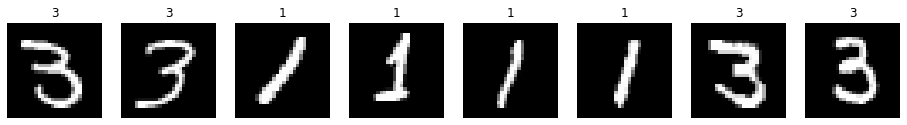

In [4]:
batch_size = 64
num_threads = 8

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

(data, labels) = next(iter(train_loader))

img_size_flat = data.size(2)**2

print(data.size())
print(labels.size())

f, axarr = plt.subplots(1, 8, figsize=(16, 2))
for i in range(min(8, data.size(0))):
    axarr[i].imshow(data[i][0], cmap='gray')
    axarr[i].set_title('{}'.format(labels[i]))
    axarr[i].axis('off')

In [9]:
input_size = img_size_flat

scale = 0.1

w1 = torch.randn([input_size, 1], device=device) * scale
b1 = torch.randn([1], device=device) * scale

# w2 = torch.randn([hidden_layer_size, output_size], device=device) * scale
# b2 = torch.randn([output_size], device=device) * scale

activation_function = nn.Sigmoid()

def activation_function_derivative(x):
    s = activation_function(x)
    return s * (1 - s)

learning_rate = 0.01

def evaluate():
    right = 0
    wrong = 0
    for batch_num, (data, labels) in enumerate(test_loader):
        batch = data.to(device)
        batch = batch.reshape([batch.size()[0], img_size_flat])

        labels = labels.to(device)
        labels[labels == class1] = 0
        labels[labels == class2] = 1
        labels = labels.float()
        labels = labels.reshape([labels.size(0), 1])

        y0 = batch
        d = labels

        v1 = torch.mm(y0, w1) + b1
        y1 = activation_function(v1)
        
        outputs = y1

        wrong_in_batch = len((outputs.round() - labels.float()).nonzero())
        
        wrong += wrong_in_batch
        right += batch.size(0) - wrong_in_batch
    
    print('{} right {} wrong {:.0f}% accuracy'.format(right, wrong, right / (right + wrong) * 100.0))

for epoch in range(1):
    for batch_num, (data, labels) in enumerate(train_loader):
        batch = data.to(device)
        batch = batch.reshape([batch.size()[0], img_size_flat])

        #https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
#         one_hot_labels = torch.zeros((labels.size()[0], 10), device=device)
#         one_hot_labels[torch.arange(labels.size()[0]), labels] = 1

        labels = labels.to(device)
        labels[labels == class1] = 0
        labels[labels == class2] = 1
        labels = labels.float()
        labels = labels.reshape([labels.size(0), 1])

        y0 = batch
        d = labels

        v1 = torch.mm(y0, w1) + b1
        y1 = activation_function(v1)
        
#         v2 = torch.mm(y1, w2) + b2
#         y2 = activation_function(v2)
        
        e = d - y1
        E = torch.mean(e**2)

        delta1 = e * activation_function_derivative(v1)
#         delta1 = activation_function_derivative(v1) * torch.mm(delta2, w2.T)
        
        w1 -= learning_rate * torch.mm(y0.T, -delta1)
        b1 -= learning_rate * torch.mean(-delta1, 0)

#         w2 -= learning_rate * torch.mm(y1.T, -delta2)
#         b2 -= learning_rate * torch.mean(-delta2, 0)
        
    evaluate()

2131 right 14 wrong 99% accuracy
2136 right 9 wrong 100% accuracy
2138 right 7 wrong 100% accuracy
2138 right 7 wrong 100% accuracy
2139 right 6 wrong 100% accuracy


KeyboardInterrupt: 